# Régression linéaire

## Import des packages

In [530]:
#%pip install pandas
#%pip install numpy
#%pip install matplotlib
#%pip install sklearn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [531]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import array
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from  sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import csv
import datetime
import itertools
import pickle
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

- Chargement des données

In [532]:
def load_data(name):
    df = pd.read_csv(name)
    return df

- préparation (filtrage) des colonnes

In [533]:
def prepare_data(df):
    columns=[]
    columns_category=[]
    for col in df.columns:
        if is_numeric_dtype(df[col]):
            #print(f"La colonne '{col}' est numérique.")
            columns.append(col)
        else:
            #print(f"La colonne '{col}' n'est pas numérique.")
            columns_category.append(col)
    
    df_numeric = df[columns].astype(float)
    df_category = df[columns_category]
    return df_category, df_numeric

- transformation des catégories

In [534]:
def transform_data(data):
    encoder = OneHotEncoder()
    for col in data.columns:
        one_hot_array = encoder.fit_transform(data[[col]]).toarray()
        one_hot_df = pd.DataFrame(one_hot_array, columns = encoder.get_feature_names_out(), index = data.index)
        if col not in ("region","age_group","bmi_category"):
            data = pd.concat([data, one_hot_df.iloc[:,0]], axis=1).drop([col], axis=1)
        else:
            data = pd.concat([data, one_hot_df], axis=1).drop([col], axis=1)    
    return data           

- la normalisation (centrage et réduction)

In [535]:
def normalize_data(data, normalisation_code):
    """
    Normalise les données selon le code fourni.
    
    Args:
        data (pd.DataFrame): Données à normaliser.
        normalisation_code (int): Code de normalisation.
            - 0 : Standardisation manuelle (z-score).
            - 1 : StandardScaler.
            - 2 : MinMaxScaler.
    
    Returns:
        pd.DataFrame: Données normalisées.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Les données doivent être un DataFrame Pandas.")
    
    if normalisation_code not in [0, 1, 2]:
        raise ValueError("Code de normalisation invalide. Utiliser 0, 1 ou 2.")
    
    if normalisation_code == 0:
        # Normalisation manuelle (z-score)
        for i in range(data.shape[1]):
            mu = data.iloc[:, i].mean()
            std = data.iloc[:, i].std()
            if std != 0:  # Éviter la division par zéro
                data.iloc[:, i] = (data.iloc[:, i] - mu) / std
            else:
                data.iloc[:, i] = 0  # Si la colonne est constante, tous les z-scores sont 0
    else:
        # Normalisation avec Scikit-learn
        if normalisation_code in [1, 2]:
            scaler = StandardScaler() if normalisation_code == 1 else MinMaxScaler()
            data_scaled = scaler.fit_transform(data)
            data = pd.DataFrame(data_scaled, columns=data.columns)
    
    return data


. calcul performance

In [536]:
def calcul_Performane(y_test, y_pred):
        # Évaluation du modèle
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return r2

- Affichage

In [537]:
def plot_performance(J_all, num_epochs):
	plt.xlabel('Modeles')
	plt.ylabel('R2')
	#plt.scatter(num_epochs, J_all,c ='red', marker = 'o' )
	plt.plot(num_epochs, J_all, 'm', linewidth = "1")
	plt.plot
	plt.show()

- modélisation des données

In [538]:
def model_data(data_X, data_cible_y, num_model):
    
    # Division des données en ensembles d'apprentissage et de test
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_cible_y, shuffle=True, train_size=0.85, random_state=42, stratify=data_X['smoker_no'])

    # Modèle basé sur la moyenne (DummyRegressor)
    if num_model == 0:
        model = DummyRegressor(strategy='mean')
        model.fit(X_train, y_train)   
    elif num_model == 1:
        model = LinearRegression().fit(X_train, y_train)
    elif num_model == 2:
        model = linear_model.Lasso(alpha=0.1).fit(X_train, y_train)
    elif num_model == 3:
        model = Ridge(alpha=0.1).fit(X_train, y_train)
    elif num_model == 4:
        model = ElasticNet(random_state=0).fit(X_train, y_train)
    else:
        model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
        
    y_pred = model.predict(X_test)
    r2 = calcul_Performane(y_test, y_pred)
    return r2


In [539]:
def RRF(data_X, data_cible_y): 

    X_train, X_test, y_train, y_test =   train_test_split(data_X, data_cible_y, shuffle=True, train_size=0.85, random_state=42, stratify=data_X['smoker_no'])
    #train_test_split(data_X, data_cible_y, test_size=0.2, random_state=42)
    
    # Régression linéaire avec PolynomialFeatures
    poly = PolynomialFeatures(degree=2, include_bias=True)
    #scaler = StandardScaler()
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Modèle régression linéaire
    linear_model = LinearRegression()
    linear_model.fit(X_train_poly, y_train)
    y_pred_linear = linear_model.predict(X_test_poly)
    return(r2_score(y_test, y_pred_linear))

## Main Function

In [540]:
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    1337 non-null   float64
 1   bmi                    1337 non-null   float64
 2   children               1337 non-null   float64
 3   age_bmi                1337 non-null   float64
 4   bmi_smoker             1337 non-null   float64
 5   age_smoker             1337 non-null   float64
 6   sex_female             1337 non-null   float64
 7   smoker_no              1337 non-null   float64
 8   region_northeast       1337 non-null   float64
 9   region_northwest       1337 non-null   float64
 10  region_southeast       1337 non-null   float64
 11  region_southwest       1337 non-null   float64
 12  age_group_Jeune        1337 non-null   float64
 13  age_group_Mature       1337 non-null   float64
 14  age_group_Âgé          1337 non-null   float64
 15  bmi_

In [541]:
df = load_data("df_assurance_clean_with_log_v4_with_new_val.csv")
#df_assurance_clean_with_log
#df_assurance_clean
#df_assurance_clean_with_log_charges
#df_assurance_clean_with_log_v2_valeur_bin
#df_assurance_clean_with_log_v4_with_binage


print(df.info())
df_category, df_numeric = prepare_data(df)
df_cible = df_numeric.iloc[:,-1]
df_numeric = df_numeric[df_numeric.columns[:-1]]
#print(df_numeric)
df_category_transforme = transform_data(df_category)
#print(df_category_transforme.info())

#print(df_cible)
model_dict ={
      0:'DummyRegr',
      1:'LinearReg',
      2:'Lasso',
      3:'Ridge',
      4:'ElasticNet',
             }

combined_df = pd.concat([df_numeric, df_category_transforme], axis=1)
#print(combined_df.info())
# Afficher les colonnes combinées
#print(combined_df.columns)

columns = combined_df.columns
#print(columns)

performances=[]
n_epochs = []
count = 0

#df_subset_normalizes = normalize_data(combined_df, 0)
#performances.append(model_data(df_subset_normalizes, df_cible, 3))
#print(performances)
date_now = datetime.datetime.today()
# Reformater la date pour éviter les caractères spéciaux
formatted_date = date_now.strftime("%Y-%m-%d_%H-%M-%S")
file_name = "results_RL_Norm1_" + formatted_date + ".csv"

Selection = False

with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["i", "j", "k", "l", "result"])  # En-têtes
                    
    if Selection : 
        for r in range(1, len(columns) + 1):  # Longueur des combinaisons, de 1 à nombre de colonnes
            combinaisons = list(itertools.combinations(columns, r))
            #print(combinaisons)
            for combinaison in combinaisons:
                df_subset = combined_df[list(combinaison)]  # Sous-ensemble du DataFrame
                
                #for normalisation in range(3):# on utilise qu'une méthode de normalisation pour le moment
                #    df_subset_normalizes = normalize_data(df_subset, normalisation)
                df_subset_normalizes = normalize_data(df_subset, 1)


                    #for methode_modelisation in range(6):#:# on utilise que deux méthode de modélisation linéaire pour le moment
                resultat = RRF(df_subset_normalizes, df_cible)
                performances.append(resultat)
                n_epochs.append(count)
                count +=1
                writer.writerow([r, combinaison, 1, 6, resultat])
        
        plot_performance(performances, n_epochs )
        #performances.append(r2)
        #print(performances)
    else:
        combined_df_normalizes = normalize_data(combined_df, 1)
        resultat = RRF(combined_df_normalizes, df_cible)
        writer.writerow(['All','ALL', 1, 'RFF', resultat])
        print("performances R2: ", resultat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1337 non-null   int64  
 1   sex           1337 non-null   object 
 2   bmi           1337 non-null   float64
 3   children      1337 non-null   int64  
 4   smoker        1337 non-null   object 
 5   region        1337 non-null   object 
 6   age_bmi       1337 non-null   float64
 7   age_group     1337 non-null   object 
 8   bmi_category  1337 non-null   object 
 9   bmi_smoker    1337 non-null   float64
 10  age_smoker    1337 non-null   int64  
 11  charges       1337 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 125.5+ KB
None
performances R2:  0.836282793318869


. Utilisation de PolynomialFeatures pour améliorer les performances

In [542]:
# Chargement des données
#('age', 'bmi', 'children', 'smoker_no', 'region_northwest', 'region_southeast', 'region_southwest')
#combined_df_selection = combined_df[['age', 'bmi', 'children', 'smoker_no', 'region_northwest', 'region_southeast', 'region_southwest']]
#print(combined_df_selection.info)
combined_df = normalize_data(combined_df, 1)
X_train, X_test, y_train, y_test = train_test_split(combined_df, df_cible, shuffle=True, train_size=0.85, random_state=42, stratify=combined_df['smoker_no'])
#train_test_split(combined_df, df_cible, test_size=0.2, random_state=42)


# Régression linéaire avec PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=True)
#scaler = StandardScaler()
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Modèle régression linéaire
linear_model = LinearRegression()
linear_model.fit(X_train_poly, y_train)
y_pred_linear = linear_model.predict(X_test_poly)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)
print(f"Régression linéaire R2: {r2_linear:.3f}")

# Forêt aléatoire avec PolynomialFeatures
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_poly, y_train)
y_pred_rf = rf_model.predict(X_test_poly)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf= r2_score(y_test, y_pred_rf)
print(f"Forêt aléatoire R2: {r2_rf:.3f}")


Régression linéaire R2: 0.836
Forêt aléatoire R2: 0.830


. Utilisation des pipelines

In [543]:
df.head()

,age,sex,bmi,children,smoker,region,age_bmi,age_group,bmi_category,bmi_smoker,age_smoker,charges
0,19,female,27.900,0,yes,southwest,530.100,Jeune,Surpoids,27.9,19,16884.92400
1,18,male,33.770,1,no,southeast,607.860,Jeune,Surpoids,0.0,0,1725.55230
2,28,male,33.000,3,no,southeast,924.000,Jeune,Surpoids,0.0,0,4449.46200
3,33,male,22.705,0,no,northwest,749.265,Mature,Normal,0.0,0,21984.47061
4,32,male,28.880,0,no,northwest,924.160,Mature,Surpoids,0.0,0,3866.85520


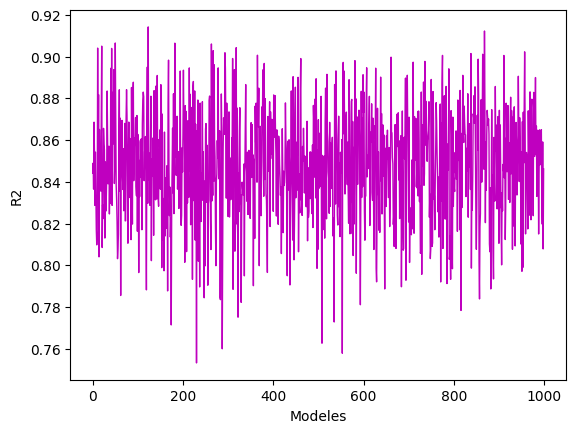

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'bmi_smoker', 'age_smoker',
                                                   'age_bmi']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['region', 'age_group',
                                                   'bmi_category'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(min_samples_split=4, n_estimators=41,
                                           random_state=42))])

In [544]:
numeric_features = ['age', 'bmi', 'children','bmi_smoker','age_smoker','age_bmi']#'log_age','log_bmi','log_children']
categorical_features = ['sex','smoker']
ordinal_features = ['region','age_group','bmi_category']

df_cible = df.iloc[:,-1]
df_numeric = df[df.columns[:-1]]
# Chargement des données
X_train, X_test, y_train, y_test = train_test_split(df_numeric, df_cible, shuffle=True, train_size=0.85, random_state=42, stratify=df_numeric['smoker'])
#(df_numeric, df_cible, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Normalisation des données numériques
        ('cat', OneHotEncoder(drop='first'), categorical_features),  # Encodage des variables catégoriques
        ('ord', OrdinalEncoder(), ordinal_features)
    ], remainder='passthrough',
    )
#print(preprocessor)
# Création d'un pipeline avec prétraitement et modèle
# Régression linéaire
lr_model = make_pipeline(preprocessor, PolynomialFeatures(2,include_bias=True), LinearRegression())
lr_model.fit(X_train, y_train)

score_ = []
state_ = []
for i in range(1000):
    X_train_, X_test_, y_train_, y_test_  = train_test_split(df_numeric, df_cible, test_size=0.2, random_state=i)
    clf_ = make_pipeline(preprocessor, PolynomialFeatures(2,), LinearRegression())
    clf_.fit(X_train_, y_train_)
    y_pred_ = clf_.predict(X_test_)
    score_.append(r2_score(y_test_, y_pred_))
    state_.append(i)
plot_performance(score_, state_)

# Forêt aléatoire #n_estimators=100, max_depth=4,random_state=42
rf_model = make_pipeline(preprocessor, PolynomialFeatures(2,), RandomForestRegressor(n_estimators=30, max_depth=4, min_samples_split=5,random_state=42))
rf_model.fit(X_train, y_train)

#DecisionTreeRegressor
tr_model = make_pipeline(preprocessor, PolynomialFeatures(2,), DecisionTreeRegressor(max_depth=4, min_samples_split=4,random_state=42))
tr_model.fit(X_train, y_train)

#GradientBoostingRegressor
gb_model = make_pipeline(preprocessor, GradientBoostingRegressor())
gb_model.fit(X_train, y_train)

#GradientBoostingRegressor_reg
gbreg_model = make_pipeline(preprocessor, GradientBoostingRegressor(n_estimators=41, max_depth=3, min_samples_split=4, random_state=42))
gbreg_model.fit(X_train, y_train)

In [545]:
# Prédictions
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_tr = tr_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)
y_pred_gbreg = gbreg_model.predict(X_test)

# Evaluation
mse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("Score :", rf_model.score(X_test, y_test))

mse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

r2_tr = r2_score(y_test, y_pred_tr)
r2_gb = r2_score(y_test, y_pred_gb)
r2_gbreg = r2_score(y_test, y_pred_gbreg)

# Affichage des résultats
print("\nRésultats Régression Linéaire après Normalisation")
print("MSE :", mse_lr)
print("R² :", r2_lr)

print("\nRésultats Forêt Aléatoire après Normalisation")
print("MSE :", mse_rf)
print("R² :", r2_rf)

print("\nRésultats DecisionTreeRegressor après Normalisation")
print("R² :", r2_tr)

print("\nRésultats DecisionTreeRegressor après Normalisation")
print("R² :", r2_gb)

print("\nRésultats DecisionTreeRegressor après Normalisation")
print("R² :", r2_gbreg)

Score : 0.9195043093907227

Résultats Régression Linéaire après Normalisation
MSE : 3514.3324961432836
R² : 0.9147744147938601

Résultats Forêt Aléatoire après Normalisation
MSE : 3415.4203969211494
R² : 0.9195043093907227

Résultats DecisionTreeRegressor après Normalisation
R² : 0.9116184812289161

Résultats DecisionTreeRegressor après Normalisation
R² : 0.916227891680013

Résultats DecisionTreeRegressor après Normalisation
R² : 0.9221694465505846


# Enregistrement du modèle en format.pkl

In [546]:
with open('linear_regression_model_1.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

In [547]:
from numpy import argmax
argmax(score_)

np.int64(123)

In [548]:
max(score_)

0.9142425620947738

In [549]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1337 non-null   int64  
 1   sex           1337 non-null   object 
 2   bmi           1337 non-null   float64
 3   children      1337 non-null   int64  
 4   smoker        1337 non-null   object 
 5   region        1337 non-null   object 
 6   age_bmi       1337 non-null   float64
 7   age_group     1337 non-null   object 
 8   bmi_category  1337 non-null   object 
 9   bmi_smoker    1337 non-null   float64
 10  age_smoker    1337 non-null   int64  
 11  charges       1337 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 125.5+ KB


In [550]:
print(np.logspace(-3, 3, 20))

[1.00000000e-03 2.06913808e-03 4.28133240e-03 8.85866790e-03
 1.83298071e-02 3.79269019e-02 7.84759970e-02 1.62377674e-01
 3.35981829e-01 6.95192796e-01 1.43844989e+00 2.97635144e+00
 6.15848211e+00 1.27427499e+01 2.63665090e+01 5.45559478e+01
 1.12883789e+02 2.33572147e+02 4.83293024e+02 1.00000000e+03]


In [551]:
print(np.linspace(0.001, 1.0, 100))

[0.001      0.01109091 0.02118182 0.03127273 0.04136364 0.05145455
 0.06154545 0.07163636 0.08172727 0.09181818 0.10190909 0.112
 0.12209091 0.13218182 0.14227273 0.15236364 0.16245455 0.17254545
 0.18263636 0.19272727 0.20281818 0.21290909 0.223      0.23309091
 0.24318182 0.25327273 0.26336364 0.27345455 0.28354545 0.29363636
 0.30372727 0.31381818 0.32390909 0.334      0.34409091 0.35418182
 0.36427273 0.37436364 0.38445455 0.39454545 0.40463636 0.41472727
 0.42481818 0.43490909 0.445      0.45509091 0.46518182 0.47527273
 0.48536364 0.49545455 0.50554545 0.51563636 0.52572727 0.53581818
 0.54590909 0.556      0.56609091 0.57618182 0.58627273 0.59636364
 0.60645455 0.61654545 0.62663636 0.63672727 0.64681818 0.65690909
 0.667      0.67709091 0.68718182 0.69727273 0.70736364 0.71745455
 0.72754545 0.73763636 0.74772727 0.75781818 0.76790909 0.778
 0.78809091 0.79818182 0.80827273 0.81836364 0.82845455 0.83854545
 0.84863636 0.85872727 0.86881818 0.87890909 0.889      0.89909091
 0.90

Training Ridge...

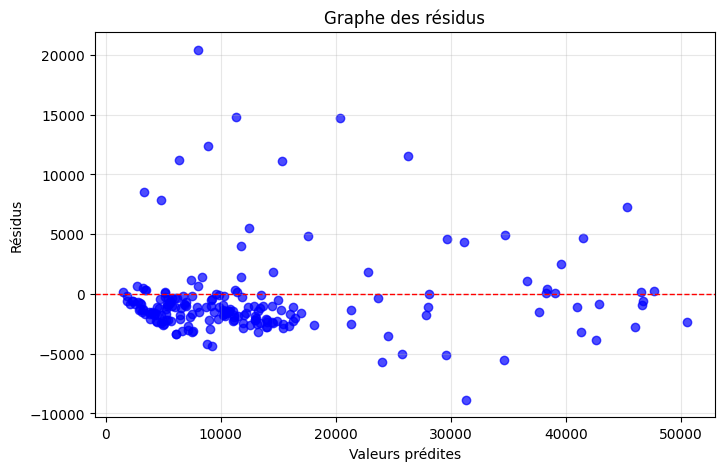

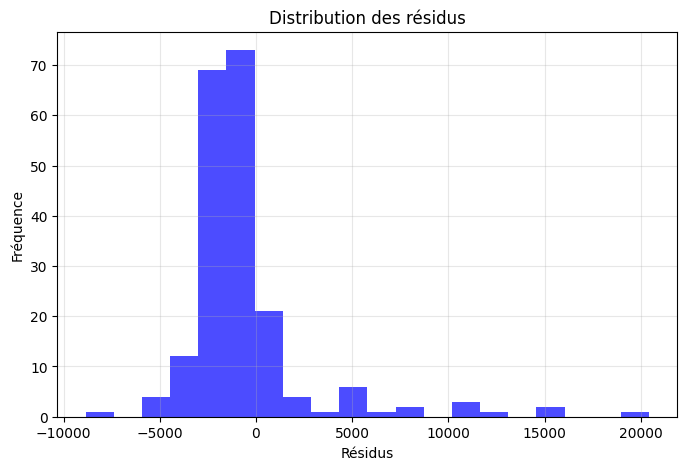

Statistique de test Shapiro-Wilk : 0.6680779030549598
p-value : 1.225435585598738e-19
Les résidus ne suivent pas une distribution normale.
Training Lasso...


c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.091e+09, tolerance: 1.315e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+10, tolerance: 1.298e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

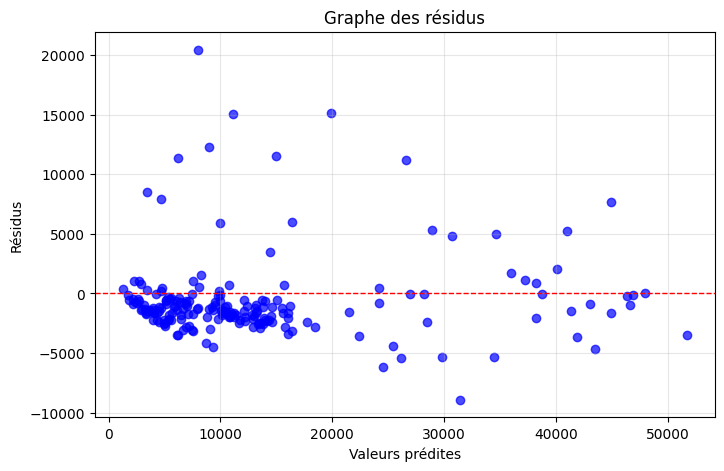

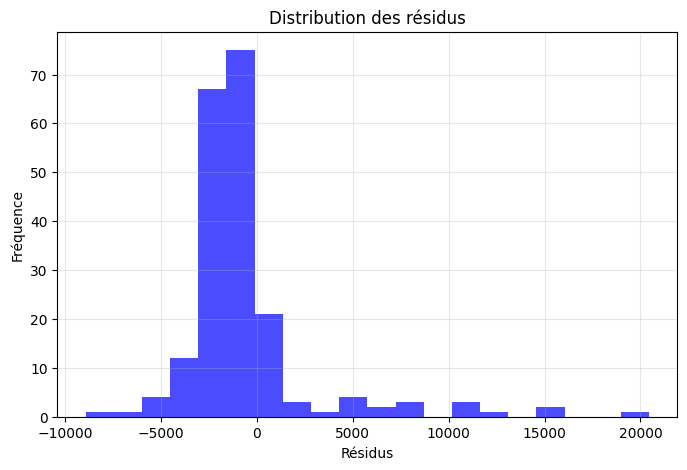

Statistique de test Shapiro-Wilk : 0.6746161293599071
p-value : 1.8568767579935644e-19
Les résidus ne suivent pas une distribution normale.

Model: Ridge
 - MSE: 12392637.539979015
 - R2: 0.9144838691816665
 - Best Params: {'model__alpha': np.float64(0.1623776739188721)}

Model: Lasso
 - MSE: 12909651.668294016
 - R2: 0.9109161825056639
 - Best Params: {'model__alpha': np.float64(0.1)}


In [552]:
df_cible = df.iloc[:,-1]
df_numeric = df[df.columns[:-1]]
# Chargement des données
X_train, X_test, y_train, y_test = train_test_split(df_numeric, df_cible, shuffle=True, train_size=0.85, random_state=42, stratify=df_numeric['smoker'])

#train_test_split(df_numeric, df_cible, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Normalisation des données numériques
        ('cat', OneHotEncoder(drop='first'), categorical_features),  # Encodage des variables catégoriques
        ('ord', OrdinalEncoder(), ordinal_features)
    ], remainder='passthrough',
    )

# Modèles à tester
models = {
    #'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    #'ElasticNet': ElasticNet()
}

# Ajout de caractéristiques polynomiales
polynomial_preprocessor = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=True))
])

# Hyperparamètres pour optimisation
param_grid = {
    'Ridge': {'model__alpha': np.logspace(-3, 3, 20)},
    'Lasso': {'model__alpha': np.linspace(0.09, 0.1, 20) },
    'ElasticNet': {
        'model__alpha': np.linspace(0.09, 0.5, 20) ,
        'model__l1_ratio': np.linspace(0.09, 0.5, 20) 
    }
}

# Résultats
results = {}

# Entraîner et évaluer chaque modèle
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Choix de la préprocessing
    if model_name == 'LinearRegression':
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('preprocessor', polynomial_preprocessor),
            ('model', model)
        ])
    
    if model_name in param_grid:
        # Optimisation des hyperparamètres avec GridSearchCV
        search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='r2')
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
    else:
        # Pas d'optimisation pour la régression linéaire
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        best_params = None
    
    # Évaluation
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    residuals = y_test - y_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, color="blue", alpha=0.7)
    plt.axhline(y=0, color="red", linestyle="--", linewidth=1)  # Ligne centrale (résidu = 0)
    plt.title("Graphe des résidus")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.hist(residuals, bins=20, color="blue", alpha=0.7)
    plt.title("Distribution des résidus")
    plt.xlabel("Résidus")
    plt.ylabel("Fréquence")
    plt.grid(alpha=0.3)
    plt.show()

    from scipy.stats import shapiro
    
    stat, p_value = shapiro(residuals)
    print("Statistique de test Shapiro-Wilk :", stat)
    print("p-value :", p_value)

    if p_value > 0.05:
        print("Les résidus semblent suivre une distribution normale.")
    else:
        print("Les résidus ne suivent pas une distribution normale.")
    results[model_name] = {
        'MSE': mse,
        'R2': r2,
        'Best Params': best_params
    }

# Afficher les résultats
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f" - MSE: {metrics['MSE']}")
    print(f" - R2: {metrics['R2']}")
    if metrics['Best Params']:
        print(f" - Best Params: {metrics['Best Params']}")
